In [2]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
%matplotlib inline

spark = SparkSession.builder.getOrCreate()

In [3]:
# local
df = spark \
    .read \
    .csv("saida_floresta.csv", header=True, sep=";", inferSchema=True) \
    .withColumn("volume_vazao", regexp_replace(col("volume_vazao"), ",", ".").cast("float")) \
    .withColumn("volume_chuva", regexp_replace(col("volume_chuva"), ",", ".").cast("float")) \
    .withColumn("data", to_date("data", "dd/MM/yyyy")) \
    .withColumn("flag_ong", when(col("data") > "2005-12-31",1).otherwise(0)) \
    .distinct()
     
# Cluster
#df = spark.read.csv("hdfs://elephant:8020/user/labdata/chuvas.csv",header=True, sep=";", inferSchema=True)  

In [4]:
df.printSchema()

root
 |-- data: date (nullable = true)
 |-- volume_chuva: float (nullable = true)
 |-- volume_vazao: float (nullable = true)
 |-- floresta: integer (nullable = true)
 |-- flag_ong: integer (nullable = false)
 |-- data_inclusao_registro: string (nullable = true)



# Train Test Split and Linear Regression

In [5]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [6]:
df.write.mode("overwrite").parquet("./teste.parquet")

In [7]:
df = spark.read.parquet("./teste.parquet")

In [8]:
assembler = VectorAssembler(
    inputCols=["flag_ong", "volume_chuva", "floresta"],
    outputCol="features")

#tratamento de missing: df.na.fill(0)
output = assembler \
        .transform(df.na.fill(0)) \
        .withColumn("label", col("volume_vazao"))
          #.select(col("features"),col("label"))

In [9]:
train, test = output.randomSplit([0.7, 0.3], seed=12345)

In [10]:
lr = LinearRegression(maxIter=100, regParam=0.0001)

In [11]:
# Run TrainValidationSplit, and choose the best set of parameters.
model = lr.fit(train)

In [27]:
model.coefficients

DenseVector([0.3237, 0.1315, 0.0])

In [12]:
# Make predictions on test data. model is the model with combination of parameters
# that performed best.
model.transform(test)\
    .filter(col("data") > "2000-01-01")\
    .show()
    #.select("features", "label", "prediction")\

+----------+------------+------------+--------+--------+----------------------+--------------------+------+------------------+
|      data|volume_chuva|volume_vazao|floresta|flag_ong|data_inclusao_registro|            features| label|        prediction|
+----------+------------+------------+--------+--------+----------------------+--------------------+------+------------------+
|2000-01-08|         0.1|      11.844|27700000|       0|            30/05/2019|[0.0,0.1000000014...|11.844|2.4831113546015766|
|2000-01-16|         0.0|       4.134|27700000|       0|            30/05/2019|    [0.0,0.0,2.77E7]| 4.134| 2.469957902413329|
|2000-01-18|         0.0|       3.695|27700000|       0|            30/05/2019|    [0.0,0.0,2.77E7]| 3.695| 2.469957902413329|
|2000-02-01|        30.5|       9.076|27700000|       0|            30/05/2019|   [0.0,30.5,2.77E7]| 9.076| 6.481760760048438|
|2000-02-04|         0.0|       4.134|27700000|       0|            30/05/2019|    [0.0,0.0,2.77E7]| 4.134| 2.4

# FLAG_ONG = 0

In [13]:
df_0 = spark \
      .read \
      .csv("saida_floresta.csv", header=True, sep=";", inferSchema=True) \
      .withColumn("volume_vazao", regexp_replace(col("volume_vazao"), ",", ".").cast("float")) \
      .withColumn("volume_chuva", regexp_replace(col("volume_chuva"), ",", ".").cast("float")) \
      .withColumn("data", to_date("data", "dd/MM/yyyy")) \
      .withColumn("flag_ong", regexp_replace(col("flag_ong"), "1", "0").cast("int")) \
      .distinct()

In [14]:
assembler = VectorAssembler(
    inputCols=["flag_ong", "volume_chuva", "floresta"],
    outputCol="features")

#tratamento de missing: df_0.na.fill(0)
output0 = assembler \
         .transform(df_0.na.fill(0)) \
         .withColumn("label", col("volume_vazao"))
          #.select(col("features"),col("label"))

In [15]:
# Make predictions on test data. model is the model with combination of parameters
# that performed best.
model.transform(output0)\
     .select("data", "features", "label", "prediction")

DataFrame[data: date, features: vector, label: float, prediction: double]

In [16]:
result0 = model.transform(output0).select("data", "features", "label", "prediction")

# FLAG_ONG = 1

In [17]:
df_1 = spark \
      .read \
      .csv("saida_floresta.csv", header=True, sep=";", inferSchema=True) \
      .withColumn("volume_vazao", regexp_replace(col("volume_vazao"), ",", ".").cast("float")) \
      .withColumn("volume_chuva", regexp_replace(col("volume_chuva"), ",", ".").cast("float")) \
      .withColumn("data", to_date("data", "dd/MM/yyyy")) \
      .withColumn("flag_ong", regexp_replace(col("flag_ong"), "0", "1").cast("int")) \
      .distinct()

In [18]:
assembler = VectorAssembler(
    inputCols=["flag_ong", "volume_chuva", "floresta"],
    outputCol="features")

#tratamento de missing: df_0.na.fill(0)
output1 = assembler \
         .transform(df_1.na.fill(0)) \
         .withColumn("label", col("volume_vazao"))
          #.select(col("features"),col("label"))

In [19]:
# Make predictions on test data. model is the model with combination of parameters
# that performed best.
model.transform(output1)\
     .select("data", "features", "label", "prediction")

DataFrame[data: date, features: vector, label: float, prediction: double]

In [20]:
result1 = model.transform(output1).select("data", "features", "label", "prediction")

In [81]:
datasInicio = ["2006-01-01","2007-01-01","2008-01-01","2009-01-01","2010-01-01","2011-01-01","2012-01-01","2013-01-01","2014-01-01"]

In [82]:
datasFim = ["2006-12-31","2007-12-31","2008-12-31","2009-12-31","2010-12-31","2011-12-31","2012-12-31","2013-12-31","2014-12-31"]

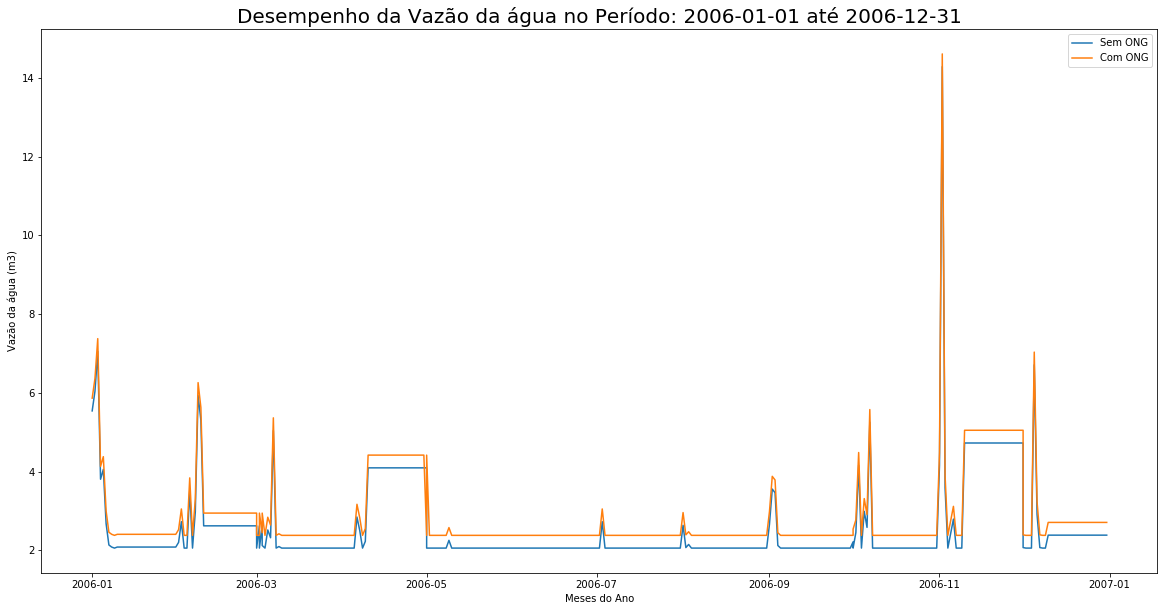

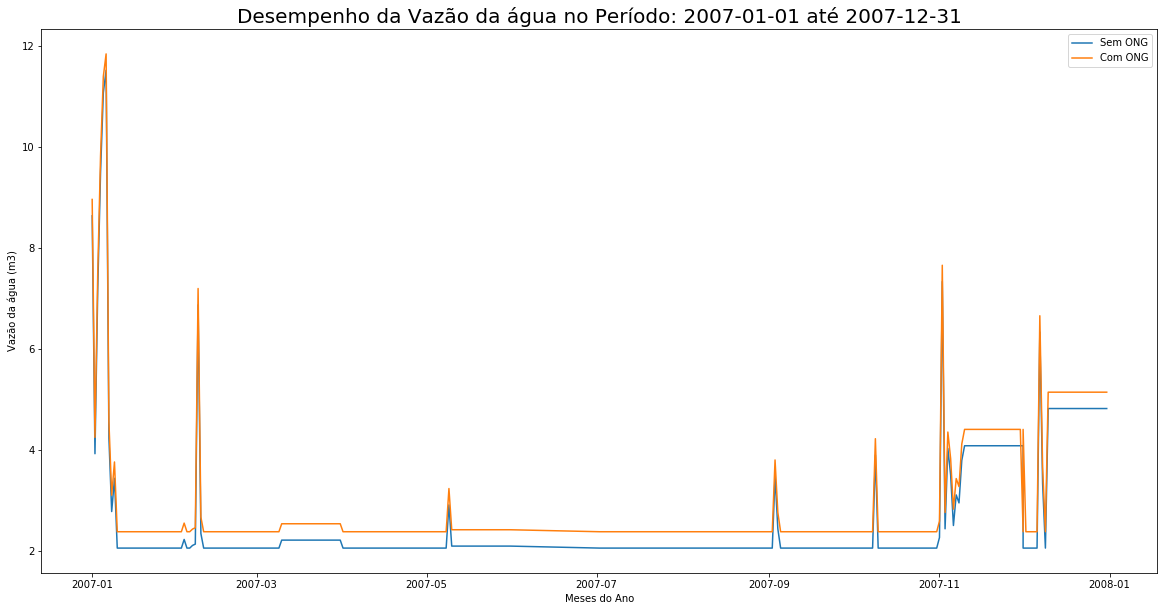

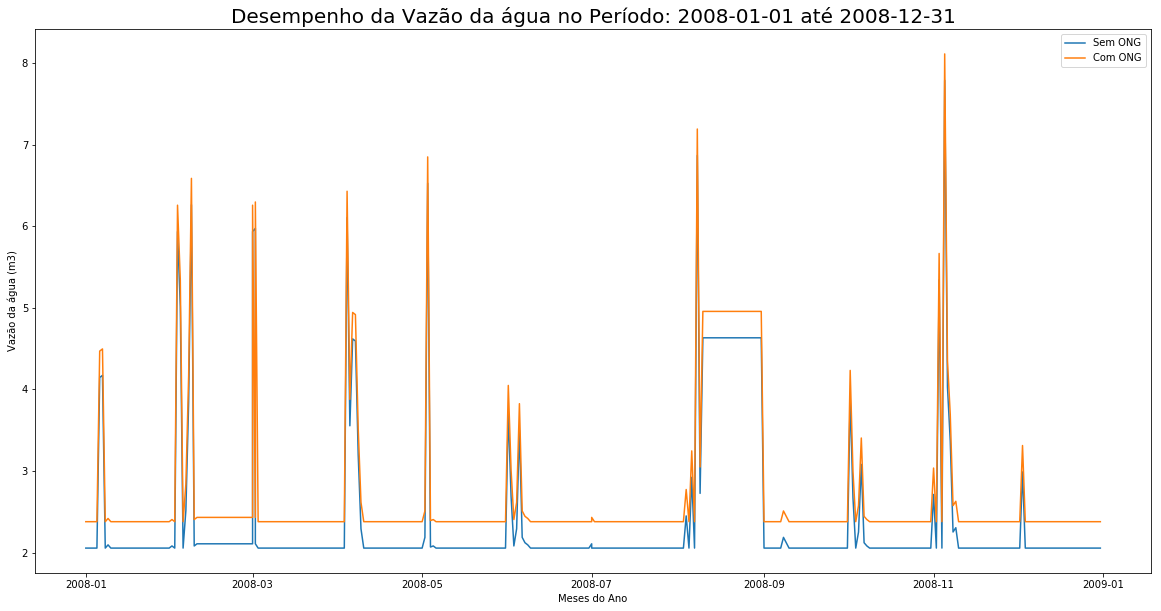

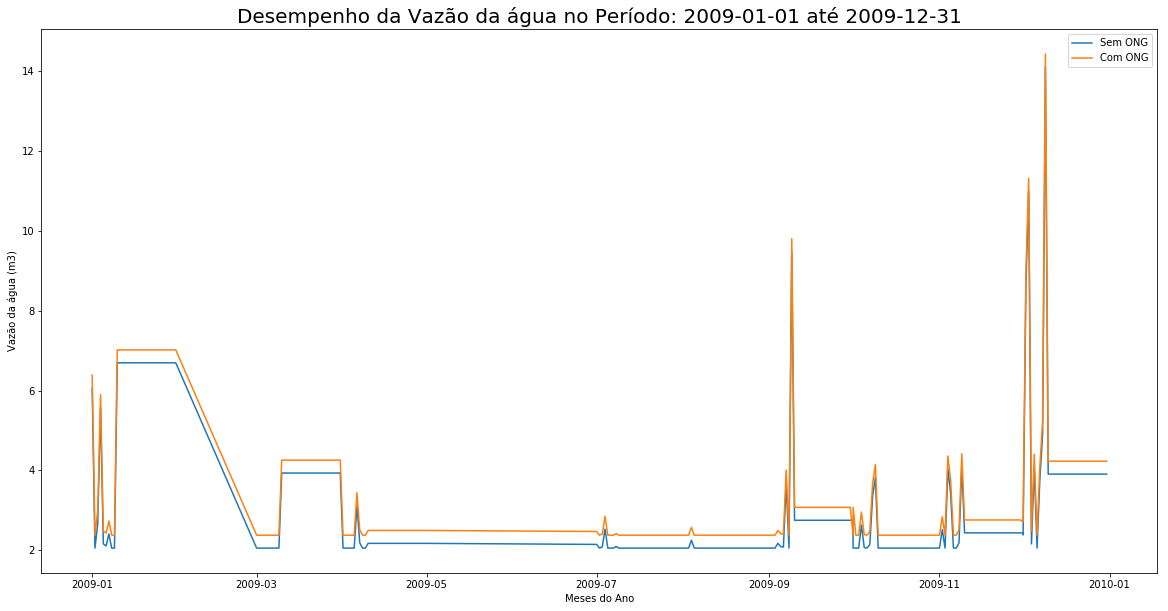

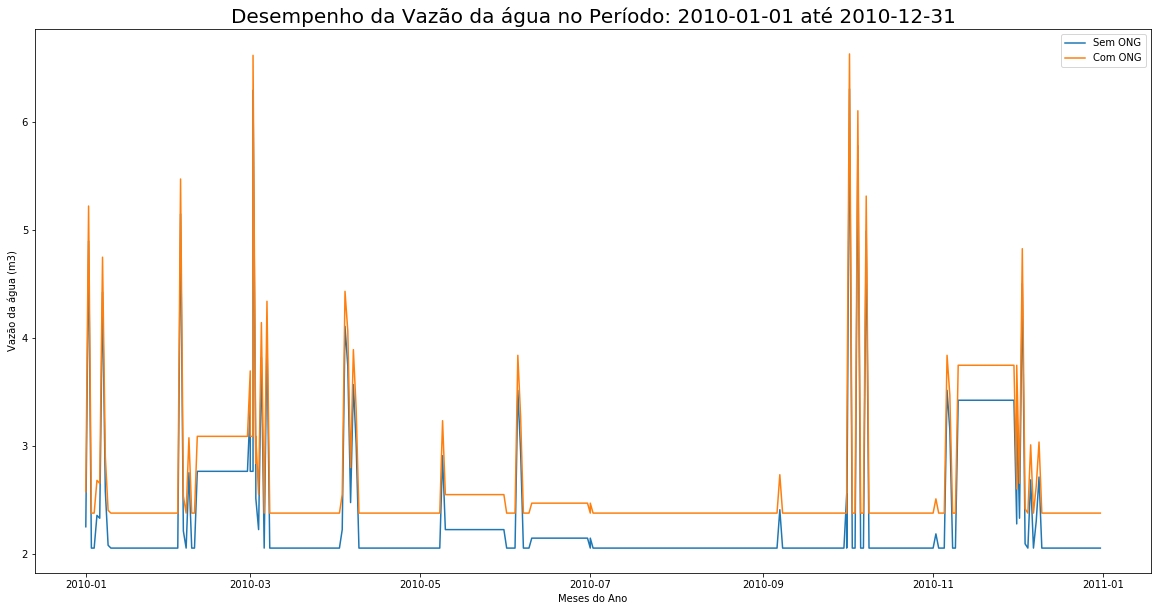

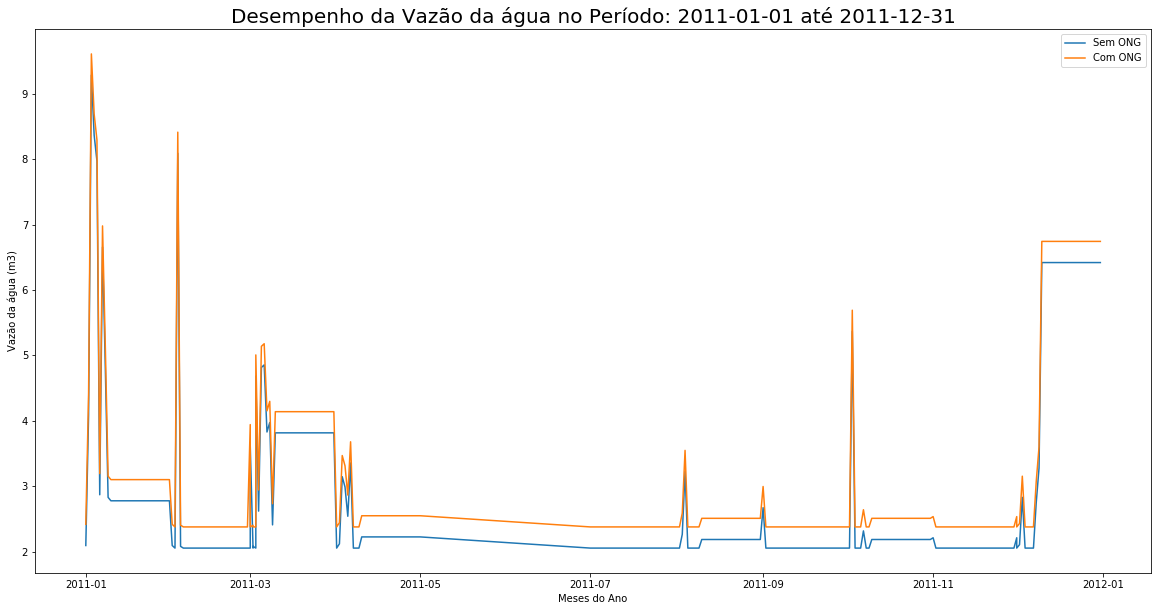

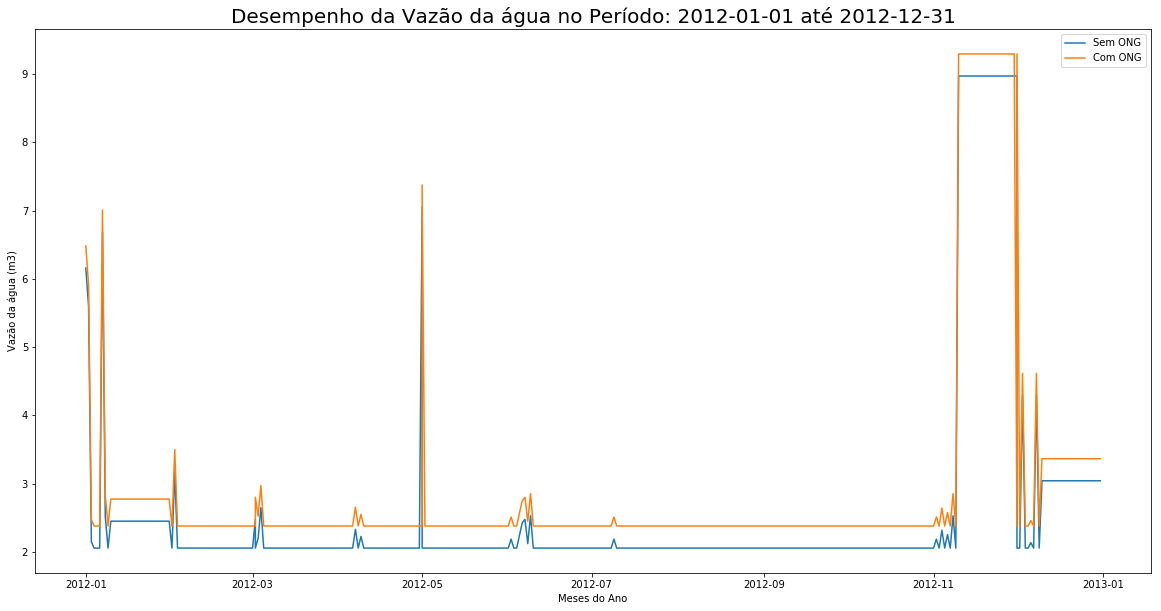

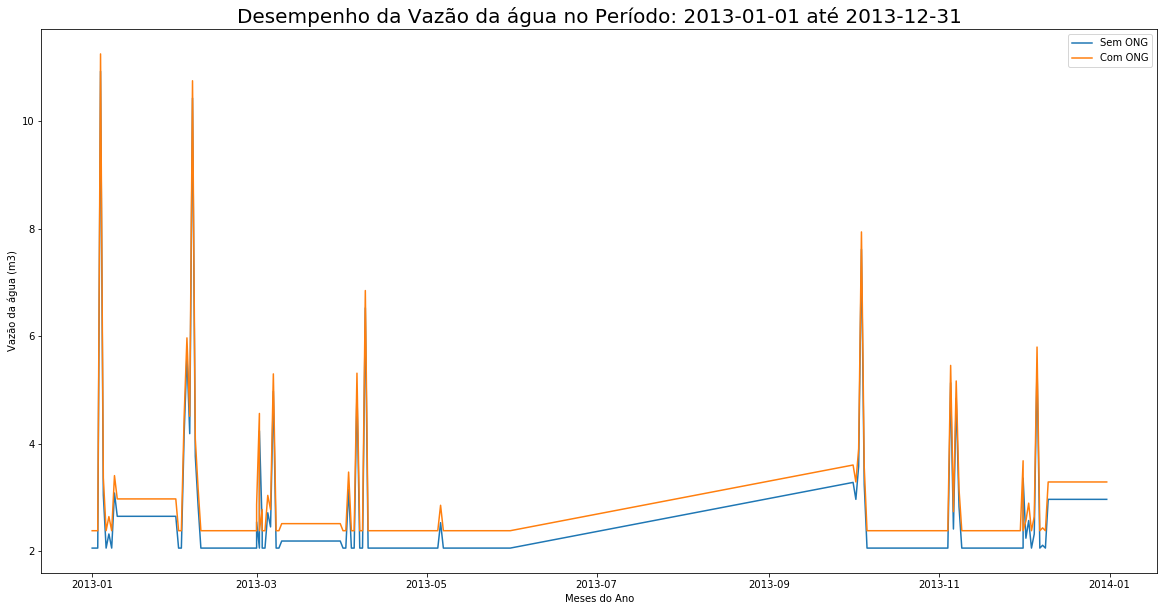

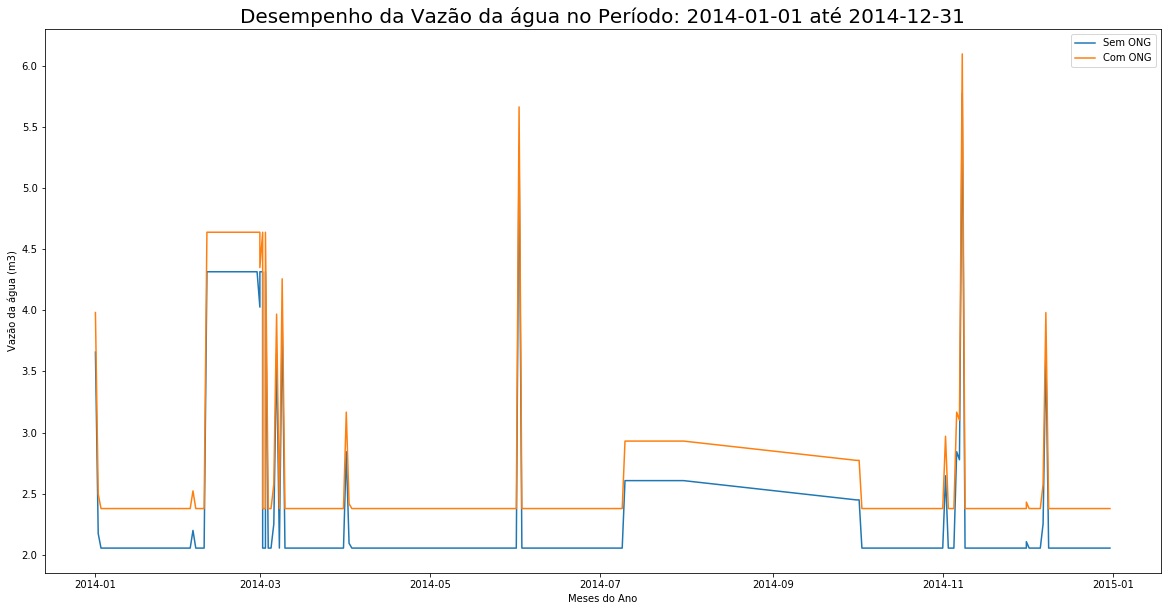

In [83]:
anos = []
totais = []
for ini, fim in zip(datasInicio, datasFim): 
    prediction0 = result0.where((col("data") >= ini) & (col("data") <= fim)) \
                     .select(col("data"), col("prediction")).orderBy("data").toPandas()
    prediction1 = result1.where((col("data") >= ini) & (col("data") <= fim)) \
                     .select(col("data"), col("prediction")).orderBy("data").toPandas()
    
    anos.append(ini)
    totais.append(((prediction1.prediction.sum() * 100) / prediction0.prediction.sum()) - 100)
    
    plt.figure(figsize=(20,10))
    plt.plot(prediction0["data"],prediction0["prediction"])
    plt.plot(prediction1["data"],prediction1["prediction"])
    plt.title('Desempenho da Vazão da água no Período: {} até {}'.format(ini,fim),size=20)
    plt.xlabel('Meses do Ano')
    plt.ylabel('Vazão da água (m3)')
    plt.legend(['Sem ONG','Com ONG'])
    #plt.ylim([2,100])
    plt.show()
    

In [38]:
#prediction0 = result0.where((col("data") >= "2006-01-01") & (col("data") <= "2006-12-31")) \
#                     .select(col("data"), col("prediction")).orderBy("data").toPandas()

In [39]:
#prediction1 = result1.where((col("data") >= "2006-01-01") & (col("data") <= "2006-12-31")) \
#                     .select(col("data"), col("prediction")).orderBy("data").toPandas()

In [84]:
anos = [x.split('-')[0] for x in anos]

In [86]:
#totais

(0, 20)

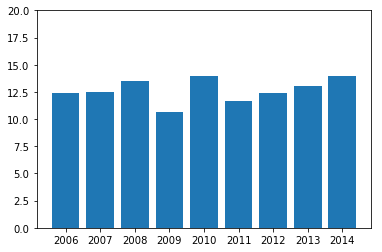

In [87]:
plt.bar(anos, totais)
plt.ylim([0,20])

In [58]:
com_ong_2006 = prediction1.prediction.sum()
com_ong_2006

1001.7451739245121

In [50]:
((prediction1.prediction.sum() * 100) / prediction0.prediction.sum()) - 100

12.383370793454517

In [ ]:
100 - 100%
110 - x

100x = 11000
x = 11000/100

In [54]:
11000/100 - 100

10.0

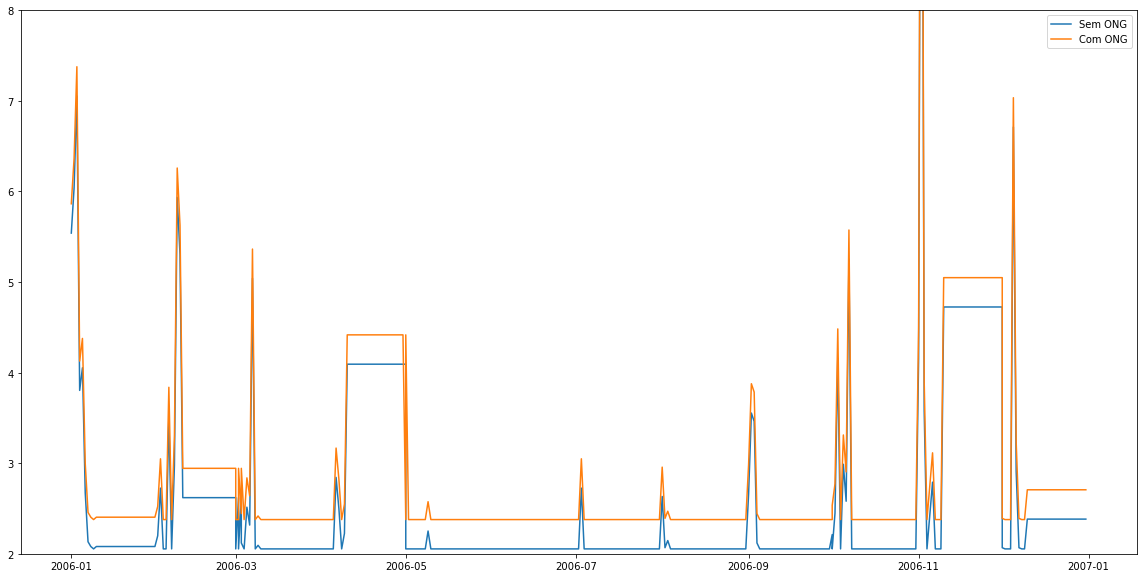

In [26]:
plt.figure(figsize=(20,10))
plt.plot(prediction0["data"],prediction0["prediction"])
plt.plot(prediction1["data"],prediction1["prediction"])
plt.legend(['Sem ONG','Com ONG'])
plt.ylim([2,8])
plt.show()